# **Estimate the day-ahead merit-order effect of renewable energy for Sweden**

#### **Setting Libraries**

In [1]:
pip install statsmodels --upgrade --pre

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

#### **Loading the data**

In [3]:
# Load the pre_panel dataframe
pre_panel = pd.read_csv('pre_panel.csv')

# Sorting by 'entity' and 'time' in descending order
pre_panel = pre_panel.sort_values(by=['subject_id', 'date'], ascending=[True, True])

# Convert the date column to datetime format
pre_panel['date'] = pd.to_datetime(pre_panel['date'], utc=True, format='%Y-%m-%d %H:%M:%S')

#### **Cleaning Database and Creating Dummy and First Difference Variables**

In [4]:
# Rename 'subject_id' to 'entity' and 'date' to 'time'
pre_panel = pre_panel.rename(columns={'subject_id': 'zona', 'date': 'fecha'})

# Create 'dum_ss' and 'dum_aw'
pre_panel['dum_ss'] = pre_panel['mes'].isin([3, 4, 5, 6, 7, 8]).astype(int)
pre_panel['dum_aw'] = pre_panel['mes'].isin([9, 10, 11, 12, 1, 2]).astype(int)

# Create 'dum_wd' and 'dum_we'
pre_panel['dum_wd'] = pre_panel['wd'].isin([1, 2, 3, 4]).astype(int)
pre_panel['dum_we'] = pre_panel['wd'].isin([5, 6, 7]).astype(int)

In [5]:
def calculate_first_differences(df, col_list):
    for col in col_list:
        df[col + "_diff"] = df[col] - df[col].shift(periods=168)

zonas = pre_panel["zona"].unique()
for zona in zonas:
    sub_df = pre_panel[pre_panel["zona"] == zona]
    calculate_first_differences(sub_df, ["price", "hydro", "solar", "wind", "other", "load_var"])
    if zona == 1:
        panel_z1 = sub_df
    elif zona == 2:
        panel_z2 = sub_df
    elif zona == 3:
        panel_z3 = sub_df
    elif zona == 4:
        panel_z4 = sub_df

/var/folders/0j/w3qt49pj7d19pfkd8ry8bfsh0000gn/T/ipykernel_41889/1234052956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + "_diff"] = df[col] - df[col].shift(periods=168)
/var/folders/0j/w3qt49pj7d19pfkd8ry8bfsh0000gn/T/ipykernel_41889/1234052956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + "_diff"] = df[col] - df[col].shift(periods=168)
/var/folders/0j/w3qt49pj7d19pfkd8ry8bfsh0000gn/T/ipykernel_41889/1234052956.py:3: SettingWithCopyWarning: 
A value is trying to be set on a co

In [6]:
# Concat the DataFrames in the desired order
panel_full = pd.concat([panel_z1, panel_z2, panel_z3, panel_z4], axis=0, ignore_index=True)

#### **Creating a Cube Transformation** 

In [ ]:
# Transform the specified variables to cube root
panel_full['price_cube_root'] = np.cbrt(panel_full['price'])
panel_full['hydro_cube_root'] = np.cbrt(panel_full['hydro'])
panel_full['solar_cube_root'] = np.cbrt(panel_full['solar'])
panel_full['wind_cube_root'] = np.cbrt(panel_full['wind'])
panel_full['other_cube_root'] = np.cbrt(panel_full['other'])
panel_full['load_var_cube_root'] = np.cbrt(panel_full['load_var'])

#### **Creating the Panel**

In [7]:
# Create a definite Pane
panel = panel_full
# Check for missing values in pre_panel
missing_values = panel.isnull().sum()
# Display the columns with missing values, if any
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
load_a              8
hydro              16
solar             192
wind              192
other              16
load_var            8
price_diff        672
hydro_diff        700
solar_diff       1056
wind_diff        1056
other_diff        700
load_var_diff     684
dtype: int64


In [8]:
# Dropping Missing Values
panel = panel.dropna()
# Rename 'subject_id' to 'entity' and 'date' to 'time'
panel = panel.rename(columns={'zona': 'id', 'fecha': 'time'})
# Generating External Index
time_index = pd.Index(pre_panel['fecha'])
entity_index = pd.Index(pre_panel['zona'])

In [9]:
# Seting Multindex
panel.set_index(['time','id'], inplace=True)

## **Descriptive Statistics**

#### **Summary Statistics**

In [10]:
# Assuming 'pre_panel' is your DataFrame
vars = ['price', 'hydro', 'solar', 'wind', 'other', 'load_var']

# Calculate mean, standard deviation, min, 25%, 50%, 75%, and max
mean_values = panel_full[vars].apply(np.mean)
std_dev_values =panel_full[vars].apply(np.std)
min_values = panel_full[vars].min()
q25_values = panel_full[vars].quantile(0.25)
median_values = panel_full[vars].median()
q75_values = panel_full[vars].quantile(0.75)
max_values = panel_full[vars].max()

# Create a DataFrame to display the summary statistics
summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Std Dev': std_dev_values,
    'Min': min_values,
    '25%': q25_values,
    'Median': median_values,
    '75%': q75_values,
    'Max': max_values
})

print(summary_stats)

                 Mean      Std Dev      Min     25%   Median        75%  \
price       75.173247    93.675680   -60.04   17.27    41.17    96.0025   
hydro     1919.621601  1690.214337     6.00  297.00  1433.00  3152.0000   
solar       31.834021    85.070117     0.00    0.00     0.00    10.0000   
wind       961.081585   873.290928     3.00  313.00   716.00  1331.0000   
other      222.446578   275.697313     0.00   41.00   126.00   255.0000   
load_var    45.253517   234.750108 -6441.00  -77.00    37.00   162.0000   

              Max  
price      799.97  
hydro     6577.00  
solar      745.00  
wind      7017.00  
other     1463.00  
load_var  1734.00  


In [11]:
# Assuming 'pre_panel' is your DataFrame
vars = ['price_diff', 'hydro_diff', 'solar_diff', 'wind_diff', 'other_diff', 'load_var_diff']

# Calculate mean, standard deviation, min, 25%, 50%, 75%, and max
mean_values = panel_full[vars].apply(np.mean)
std_dev_values =panel_full[vars].apply(np.std)
min_values = panel_full[vars].min()
q25_values = panel_full[vars].quantile(0.25)
median_values = panel_full[vars].median()
q75_values = panel_full[vars].quantile(0.75)
max_values = panel_full[vars].max()

# Create a DataFrame to display the summary statistics
summary_stats_d = pd.DataFrame({
    'Mean': mean_values,
    'Std Dev': std_dev_values,
    'Min': min_values,
    '25%': q25_values,
    'Median': median_values,
    '75%': q75_values,
    'Max': max_values
})

print(summary_stats_d)

                   Mean      Std Dev      Min     25%  Median     75%      Max
price_diff    -0.056536    81.686985  -561.17  -27.23    0.13   28.52   583.91
hydro_diff     0.207819   830.055135 -4560.00 -214.00    0.00  246.00  4442.00
solar_diff     0.037760    36.452284  -573.00    0.00    0.00    0.00   512.00
wind_diff      5.383721  1008.782608 -6737.00 -513.00    2.00  531.00  4789.00
other_diff    -0.476372    94.512297  -747.00  -20.00    0.00   20.00   767.00
load_var_diff  0.080909   304.541995 -6510.00 -158.00   -1.00  156.00  6073.00


#### **Correlation Matrix**

In [12]:
correlation_matrix = panel_full[['price_diff', 'hydro_diff', 'solar_diff', 'wind_diff', 'other_diff', 'load_var_diff']].corr()
print(correlation_matrix)

               price_diff  hydro_diff  solar_diff  wind_diff  other_diff  \
price_diff       1.000000    0.314669    0.033689  -0.399423    0.400057   
hydro_diff       0.314669    1.000000    0.010022  -0.579725    0.137865   
solar_diff       0.033689    0.010022    1.000000  -0.069540    0.091462   
wind_diff       -0.399423   -0.579725   -0.069540   1.000000   -0.253659   
other_diff       0.400057    0.137865    0.091462  -0.253659    1.000000   
load_var_diff   -0.034026   -0.130993    0.110462   0.100653   -0.033345   

               load_var_diff  
price_diff         -0.034026  
hydro_diff         -0.130993  
solar_diff          0.110462  
wind_diff           0.100653  
other_diff         -0.033345  
load_var_diff       1.000000  


In [13]:
correlation_matrix = panel_full[['price', 'hydro', 'solar', 'wind', 'other', 'load_var']].corr()
print(correlation_matrix)

             price     hydro     solar      wind     other  load_var
price     1.000000 -0.117479  0.053071 -0.309830  0.298332 -0.076663
hydro    -0.117479  1.000000 -0.240234  0.173884 -0.243660  0.061077
solar     0.053071 -0.240234  1.000000 -0.147088  0.151170  0.048624
wind     -0.309830  0.173884 -0.147088  1.000000  0.038889  0.150746
other     0.298332 -0.243660  0.151170  0.038889  1.000000 -0.024505
load_var -0.076663  0.061077  0.048624  0.150746 -0.024505  1.000000


#### **Scatter Plott**

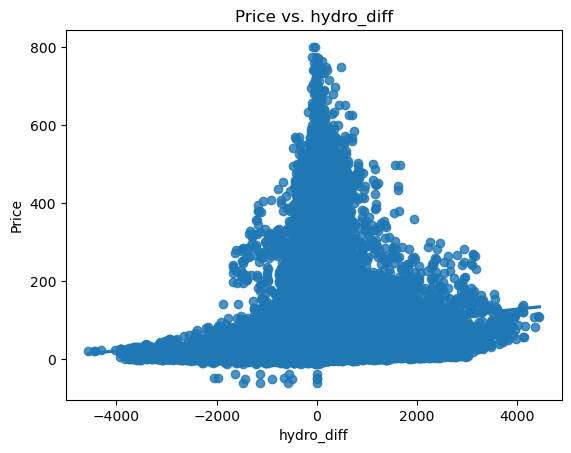

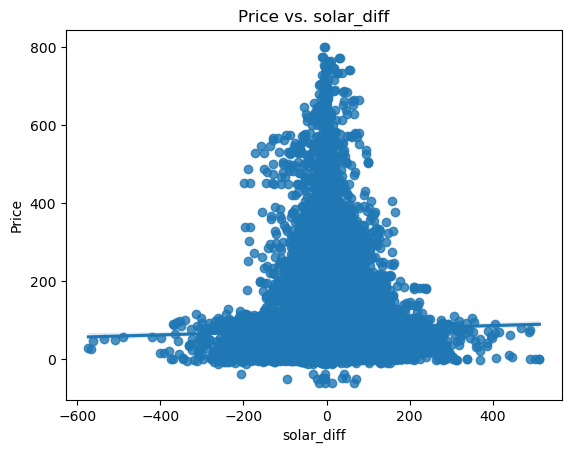

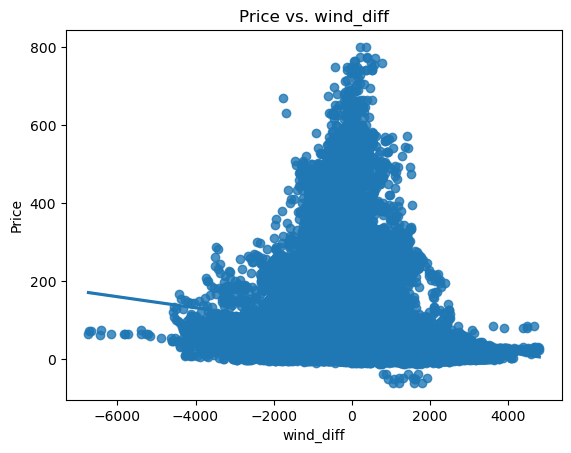

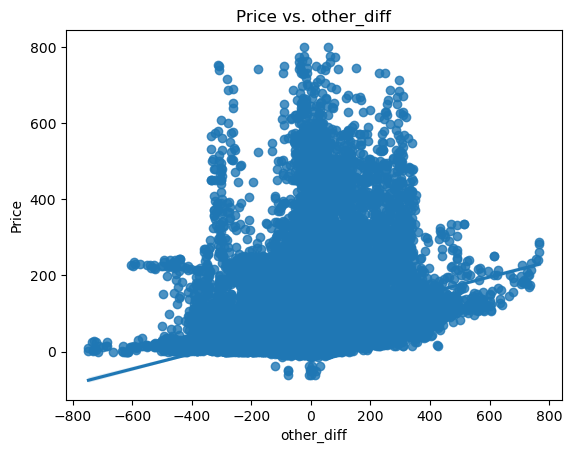

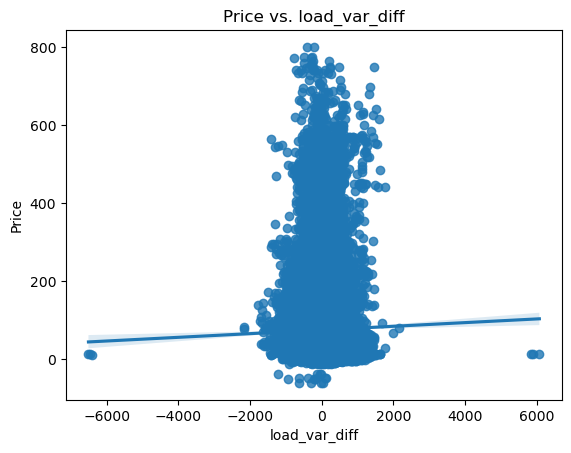

In [14]:
# Create separate scatter plots for each variable
for var in ['hydro_diff', 'solar_diff', 'wind_diff', 'other_diff', 'load_var_diff']:
    # Create a scatter plot with regression line
    sns.regplot(x=var, y='price', data=panel_full)
    plt.title(f'Price vs. {var}')
    plt.xlabel(var)
    plt.ylabel('Price')
    plt.show()

In [17]:
panel['intercept'] = 1

# Estimate the two-way fixed effect model
model = sm.OLS(panel['price_diff'], panel[['intercept', 'load_var_diff', 'hydro_diff', 'solar_diff', 'wind_diff', 'other_diff']])
results = model.fit(index=time_index, groups=entity_index, use_demeaned=True)

# Print the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             price_diff   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     4820.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:28:52   Log-Likelihood:            -3.7369e+05
No. Observations:               66020   AIC:                         7.474e+05
Df Residuals:                   66014   BIC:                         7.474e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.0126      0.270     -0.046

In [16]:
# Fixed effects model with entity and time effects
sm.OLS(panel['price'], panel[['load_var', 'hydro', 'solar', 'wind', 'other']])
FE_results = model.fit(index=time_index, groups=entity_index)
print('Fixed Effects Model:')
print(FE_results.summary())

Fixed Effects Model:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     3218.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:28:00   Log-Likelihood:            -3.8577e+05
No. Observations:               66020   AIC:                         7.716e+05
Df Residuals:                   66014   BIC:                         7.716e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     84.4443      0.70